# MH370 Synthetic Dataset

### Create corpus

In [2]:
import pandas as pd
import numpy as np
import time

# create corpus
Corpus1 = ['earthquake', 'Hawaii', 'tourists', 'pacific', 'coast', \
           'witness', 'video', 'crack', 'damage', '2019', 'reason']
Corpus2 = ['bomb', 'Russia', 'terroist', 'TNT', 'nuclear', 'duma', 'Putin', 'Soviet']
Corpus3 = ['plate', 'drift', 'natrual', 'disaster', 'volcano', 'melt', 'magma', 'mountain']
Corpus4 = ['curse', 'end', 'Voldemort', 'magic', 'black', 'mistery', 'religion', 'dragon']


### Create users and messages

In [3]:
# number of online users
UN1, UN2, UN3, UN4 = 100, 100, 100, 100

# each user say Num of tweets
Num = 10

label = []
tweet = []
user = []
# generate for Narrative1
for i in range(UN1 * Num):
    user.append(i // Num)
    label.append(0)
    tweet.append(' '.join(np.random.choice(Corpus1*1 + Corpus2*0 + Corpus3*0 + Corpus4*0, np.random.randint(10, 20))))

# generate for Narrative2
for i in range(UN2 * Num):
    user.append(i // Num + UN1)
    label.append(1)
    tweet.append(' '.join(np.random.choice(Corpus1*1 + Corpus2*1 + Corpus3*0 + Corpus4*0, np.random.randint(10, 20))))

# generate for Narrative3
for i in range(UN3 * Num):
    user.append(i // Num + UN1 + UN2)
    label.append(2)
    tweet.append(' '.join(np.random.choice(Corpus1*1 + Corpus2*0 + Corpus3*1 + Corpus4*0, np.random.randint(10, 20))))
    
# generate for Narrative4
for i in range(UN4 * Num):
    user.append(i // Num + UN1 + UN2 + UN3)
    label.append(3)
    tweet.append(' '.join(np.random.choice(Corpus1*1 + Corpus2*0 + Corpus3*0 + Corpus4*1, np.random.randint(10, 20))))

data = pd.DataFrame(np.hstack([np.array(user).reshape(-1, 1), np.array(tweet).reshape(-1, 1), np.array(label).reshape(-1, 1)]), \
             columns=['name', 'postTweet', 'label'])

def postProcess(wordList):
    return ' '.join(np.sort(wordList.split(' ')))
data.postTweet = data.postTweet.apply(lambda x: postProcess(x))

### Process

In [4]:
# user-index map
userMap = dict()
for i, user in enumerate(data.name.unique()):
    userMap[user] = i

# tweet-index map
tweetMap = dict()
for i, tweet in enumerate(data.postTweet.unique()):
    tweetMap[tweet] = i

# construct user-tweet matrix
userTweet = np.zeros((len(userMap), len(tweetMap)))


for user, tweet in data[['name', 'postTweet']].iloc[::-1].values:
    userTweet[userMap[user], tweetMap[tweet]] += 1
    
###################################################################

# construct keyword list
keywordList = []
for tweet in data.postTweet:
    keywordList += tweet.split()
keywordList = set(keywordList)
print ('keyword corpus:', len(keywordList))

# # construct user-keyword, tweet-keyword matrix
# userKey = np.zeros((len(userMap), len(keywordList)))

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=5)

# # get user-key matrix
# def returnDistUser(data, keywordList, user):
#     tempKey = []
#     tempCount = dict.fromkeys(keywordList, 0)
#     for tweet in data[data.name == user].postTweet:
#         tempKey += tweet.split()
        
#     for word in set(tempKey):
#         tempCount[word] = tempKey.count(word)
#     return list(tempCount.values())

# userKey = pd.DataFrame(userMap.keys(), columns=['name'])

# tic = time.time()
# userKey['dist'] = userKey.name.parallel_apply(lambda x: returnDistUser(data, keywordList, x))
# userKey = np.array(userKey.dist.values.tolist())
# print ('user Key success. take times,', time.time() - tic)

# get tweet-key matrix
def returnDistTweet(keywordList, tweet):
    tempKey = tweet.split()
    tempCount = dict.fromkeys(keywordList, 0)
        
    for word in set(tempKey):
        tempCount[word] = tempKey.count(word)
    return list(tempCount.values())

tweetKey = pd.DataFrame(tweetMap.keys(), columns=['tweet'])
tic2 = time.time()
tweetKey['dist'] = tweetKey.tweet.parallel_apply(lambda x: returnDistTweet(keywordList, x))
tweetKey = np.array(tweetKey.dist.values.tolist())
# print ('tweet Key success. take times,', time.time() - tic2)


# # # userKey = userKey / (userKey ** 2).sum(axis=1).reshape(-1, 1) ** 0.5
tweetKey = tweetKey / (tweetKey ** 2).sum(axis=1).reshape(-1, 1) ** 0.5

# userTweet2 = userKey @ tweetKey.T

# print ('# of users', userTweet2.shape[0], ', # of tweets', userTweet2.shape[1])

keyword corpus: 35
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Message Similarity (M-module)

In [5]:
from multiprocessing import Process
from multiprocessing import Manager

def phi(nz_index, tweetKey, index, r):
    if index in nz_index:
        return 1
    s = 0
    for i in nz_index:
        s += np.exp(- r * np.linalg.norm(np.array(tweetKey[index, :]) - np.array(tweetKey[i, :]), 2)**2) / 4
    if s < 0.2:
        return 0
    else:
        return s

# def phi2(nz_index, tweetKey, z_index, r):
#     temp = np.ones(len(z_index))
#     print (temp.shape)
#     for j in z_index:
#         if j % 1000 == 0:
#             print (j, end=' ')
#         if j in nz_index:
#             continue
#         s = 0
#         for i in nz_index:
#             s += np.exp(- r * np.linalg.norm(np.array(tweetKey[z_index, :]) - np.array(tweetKey[i, :]), 2)**2)
#         if s < 0.05:
#             temp[j] = 0
#         else:
#             temp[j] = s
#     print ()
#     return temp.reshape(1, -1)
    
def interpolation(result, userTweet, tweetKey, k):
    for i in range(userTweet.shape[0]):
        if i % 5 == k:
            print (i)
            nz_index = np.where(userTweet[i, :] > 0)[0]
            index = np.arange(userTweet.shape[1])
            result[i] = np.vectorize(phi, \
                excluded=['nz_index', 'tweetKey'])(nz_index=nz_index, tweetKey=tweetKey, index=index, r=2)

# interpolation(userTweet, tweetKey)    
manager = Manager()
result = manager.dict()

plist = []
for k in range(5):
    temp = Process(target=interpolation, args=(result, userTweet, tweetKey, k))
    plist.append(temp)
    
for i in plist:
    i.start()
for i in plist:
    i.join()  
    

userTweet = []
for _, j in sorted(dict(result).items(), key=lambda x: x[0]):
    userTweet.append(j)
userTweet = np.array(userTweet)

0
1
2
3
4
6
7
8
9
5
11
13
14
12
10
16
18
19
17
15
21
23
24
22
20
26
28
29
27
25
31
32
34
33
30
36
37
39
38
35
41
42
44
43
40
46
47
49
48
45
51
52
54
53
50
56
59
57
58
55
61
64
63
62
60
66
68
69
67
65
71
73
74
72
70
76
79
78
77
75
84
81
83
80
82
89
86
88
85
94
87
91
93
90
99
96
92
98
95
104
101
103
97
100
109
106
108
102
105
114
111
113
110
119
107
116
118
124
115
112
121
123
129
120
117
126
128
134
125
122
131
133
139
130
127
138
136
144
135
132
143
141
149
140
137
148
146
154
145
142
153
151
159
150
158
147
156
164
155
163
161
152
169
160
168
166
174
157
165
173
171
179
162
170
178
184
176
167
175
183
189
181
180
172
188
194
186
185
193
177
191
199
190
198
196
204
182
195
203
201
209
187
200
208
206
214
192
205
213
211
219
197
210
218
224
216
215
202
223
229
221
220
228
207
234
226
225
239
233
231
212
230
238
244
236
217
235
243
249
241
222
240
248
254
246
227
245
253
251
259
250
232
258
256
264
255
263
237
261
269
260
268
266
242
274
265
271
273
247
279
270
276
278
284
252
281
275
28

### Social Graph Convolution (S-Module)

In [6]:
from itertools import combinations

adjTable = np.zeros((400, 400))

# for u1, u2 in combinations(np.hstack([np.arange(100), np.arange(100, 200, 1)]), 2):
#     if np.random.random() < 0.01:
#         adjTable[u1, u2] += 1
#         adjTable[u2, u1] += 1
    
# for u1, u2 in combinations(np.hstack([np.arange(100), np.arange(200, 300, 1)]), 2):
#     if np.random.random() < 0.01:
#         adjTable[u1, u2] += 1
#         adjTable[u2, u1] += 1

# for u1, u2 in combinations(np.hstack([np.arange(100), np.arange(300, 400, 1)]), 2):
#     if np.random.random() < 0.01:
#         adjTable[u1, u2] += 1
#         adjTable[u2, u1] += 1

A = np.array(adjTable) + np.diag(np.ones(adjTable.shape[0]))
A = A / A.sum(axis=1).reshape(-1,1)
A = (A + np.diag(np.ones(A.shape[0]))) / 2

### Factorization

BSMF accuracy 0.98375
NMF accuracy 0.91775
NMTF accuracy 0.94125


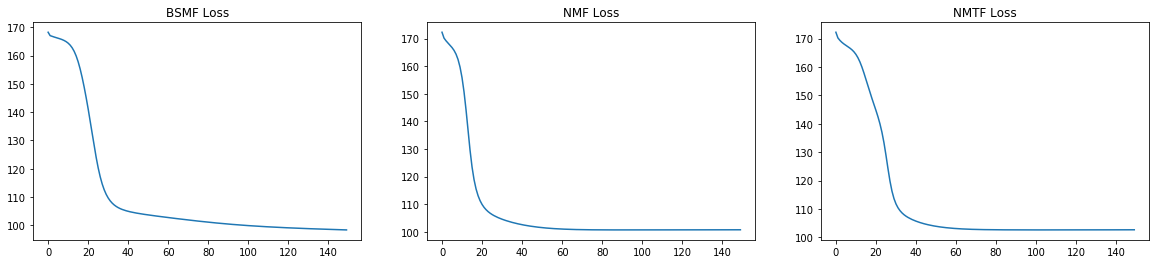

In [14]:
# np.random.seed(110)
np.random.seed(120)

N = 4
lambda1, lambda2 = 0.001, 0.001
eps = 1e-8

# observation matrix X
X = A @ userTweet

from numpy import linalg as LA

def lossFunc(X, U, B, M, lambda1, lambda2):
    loss1 = LA.norm(X - U @ B @ M.T, 'fro')
#     loss2 = lambda1 * (LA.norm(U, 1) + LA.norm(M, 1))
#     loss3 = lambda2 * (LA.norm(U, 2) + LA.norm(M, 2))
    
    return loss1# + loss2 + loss3

def decompostition(mode):
    # User-belief and Message-belief matrix
    U = np.random.rand(len(userMap), N)
#     for i in range(N):
#         for j in range(i):
#             U[:, i] -= U[:, j] * (U[:, i].T @ U[:, j]) / (U[:, j].T @ U[:, j ])**0.5
#     # U = U / U.sum(axis=1).reshape(-1, 1)
    M = np.random.rand(len(tweetMap), N)
#     for i in range(N):
#         for j in range(i):
#             M[:, i] -= M[:, j] * (M[:, i].T @ M[:, j]) / (M[:, j].T @ M[:, j ])**0.5
    # M = M / M.sum(axis=1).reshape(-1, 1)

    if mode == 'BSMF':
        B = np.array([[1, 0, 0, 0],
                      [1, 1, 0, 0],
                      [1, 0, 1, 0],
                      [1, 0, 0, 1]])
        
    elif mode == 'NMF':
        B = np.array([[1.0, 0.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0, 0.0],
                      [0.0, 0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0]])
    
    elif mode == 'NMTF':
        B = np.array([[1.0, 0.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0, 0.0],
                      [0.0, 0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0]])

    eps = 1e-8
    loss = []

    for iters in range (150):
      
        U = (U * (X @ M @ B.T)) / (U @ B @ M.T @ M @ B.T)
        
        if mode in ['naive', 'NMF', 'NMTF']:
            U -= U @ (lambda1 * np.ones((N, N)) + lambda2 * np.eye(N))
        
        U = np.clip(U, eps, np.inf)
        
        M = (M * (X.T @ U @ B)) / (M @ B.T @ U.T @ U @ B)
        
        if mode in ['naive', 'NMF', 'NMTF']:
            M -= M @ (lambda1 * np.ones((N, N)) + lambda2 * np.eye(N))
        
        M = np.clip(M, eps, np.inf)
        
        
        if mode == 'NMTF':
            B = (B * (U.T @ X @ M)) / (U.T @ U @ B @ M.T @ M)
        
            B = np.clip(B, eps, np.inf)
    
        iterLoss = lossFunc(X, U, B, M, lambda1, lambda2)
        loss.append(iterLoss)
        
    return U, M, loss, B

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
U, M, loss, B  = decompostition('BSMF')    
plt.subplot(131)
plt.plot(loss)
plt.title('BSMF Loss')
U = U / U.sum(axis=1).reshape(-1, 1)
M = M / M.sum(axis=1).reshape(-1, 1)

tempMap = []
result = []
for tweet in data.postTweet:
    tempMap.append(M[tweetMap[tweet], :])
    result.append(M[tweetMap[tweet], :].tolist())
    
tempMap = np.argmax(tempMap, axis=1)

U, M, loss, B = decompostition('NMF')    
plt.subplot(132)
plt.plot(loss)
plt.title('NMF Loss')
U = U / U.sum(axis=1).reshape(-1, 1)
M = M / M.sum(axis=1).reshape(-1, 1)

tempMap1 = []
result1 = []
for tweet in data.postTweet:
    tempMap1.append(M[tweetMap[tweet], :])
    result1.append(M[tweetMap[tweet], :].tolist())
    
tempMap1 = np.argmax(tempMap1, axis=1)

U, M, loss, B = decompostition('NMTF')    
plt.subplot(133)
plt.plot(loss)
plt.title('NMTF Loss')
U = U / U.sum(axis=1).reshape(-1, 1)
M = M / M.sum(axis=1).reshape(-1, 1)

tempMap2 = []
result2 = []
for tweet in data.postTweet:
    tempMap2.append(M[tweetMap[tweet], :])
    result2.append(M[tweetMap[tweet], :].tolist())

tempMap2 = np.argmax(tempMap2, axis=1)

Map = {'0': 0, 
       '1': 1,
       '2': 2,
       '3': 3}

from sklearn.metrics import accuracy_score
from itertools import permutations
JudgeList = []
for permu in permutations([1, 2, 3]):
    Map2 = {0: 0, 1: permu[1], 2: permu[2], 3: permu[0]}
    tempTarget = [Map2[Map[t]] for t in data.label.tolist()]
    JudgeList.append(accuracy_score(tempMap, tempTarget))
print ('BSMF accuracy', max(JudgeList))

JudgeList = []
for permu in permutations([0, 1, 2, 3]):
    Map2 = {0: permu[0], 1: permu[1], 2: permu[2], 3: permu[3]}
    tempTarget = [Map2[Map[t]] for t in data.label.tolist()]
    JudgeList.append(accuracy_score(tempMap1, tempTarget))
print ('NMF accuracy', max(JudgeList))

JudgeList = []
for permu in permutations([0, 1, 2, 3]):
    Map2 = {0: permu[0], 1: permu[1], 2: permu[2], 3: permu[3]}
    tempTarget = [Map2[Map[t]] for t in data.label.tolist()]
    JudgeList.append(accuracy_score(tempMap2, tempTarget))
print ('NMTF accuracy', max(JudgeList))